In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [optuna]


Loaded 6258 samples | 7 classes
Label mapping: {'confidentiality obligations': 0, 'governing law': 1, 'indemnification': 2, 'non-competition': 3, 'non-solicitation': 4, 'remedies': 5, 'signatures': 6}
🔹 Generating embeddings using all-mpnet-base-v2 ...


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/196 [00:00<?, ?it/s]

[I 2025-11-11 23:08:04,632] A new study created in memory with name: no-name-bb6ae818-9d20-4529-9760-57ccd6a0ac52


🔹 Running Optuna hyperparameter search ...


[I 2025-11-11 23:08:23,323] Trial 0 finished with value: 0.9627263045793397 and parameters: {'n_estimators': 255, 'max_depth': 9, 'learning_rate': 0.049382177848903246, 'subsample': 0.6266978810128113, 'colsample_bytree': 0.8728510233350821}. Best is trial 0 with value: 0.9627263045793397.
[I 2025-11-11 23:08:28,802] Trial 1 finished with value: 0.9659211927582535 and parameters: {'n_estimators': 117, 'max_depth': 4, 'learning_rate': 0.15384382065951888, 'subsample': 0.9619137610711277, 'colsample_bytree': 0.9367485986217723}. Best is trial 1 with value: 0.9659211927582535.
[I 2025-11-11 23:08:44,871] Trial 2 finished with value: 0.9616613418530351 and parameters: {'n_estimators': 287, 'max_depth': 8, 'learning_rate': 0.03668756121256072, 'subsample': 0.5423699394475778, 'colsample_bytree': 0.5851293212244528}. Best is trial 1 with value: 0.9659211927582535.
[I 2025-11-11 23:08:53,268] Trial 3 finished with value: 0.9637912673056444 and parameters: {'n_estimators': 332, 'max_depth': 7,

Best parameters found: {'n_estimators': 368, 'max_depth': 3, 'learning_rate': 0.25859482867985645, 'subsample': 0.814893160103162, 'colsample_bytree': 0.752457646367721}

 Test Accuracy: 96.70%

 Classification Report:
                             precision    recall  f1-score   support

confidentiality obligations       0.97      0.99      0.98      1527
              governing law       0.96      0.96      0.96        77
            indemnification       1.00      0.96      0.98        27
            non-competition       0.92      0.61      0.73        36
           non-solicitation       1.00      0.88      0.94        26
                   remedies       0.96      0.88      0.92       121
                 signatures       0.83      0.86      0.85        64

                   accuracy                           0.97      1878
                  macro avg       0.95      0.88      0.91      1878
               weighted avg       0.97      0.97      0.97      1878

Saved model as xgb_

<Figure size 800x500 with 0 Axes>

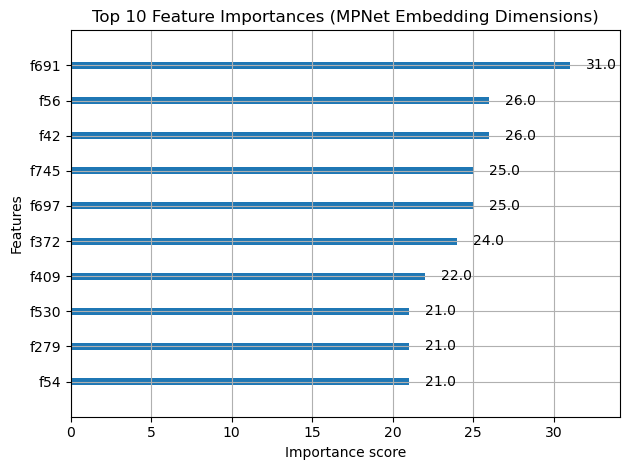

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier, plot_importance
import optuna
from sentence_transformers import SentenceTransformer
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ========== 1. Load dataset ==========
# csv_path = os.path.expanduser("Final_Classification_gemini_2.5_flash_6000_samples.csv")
csv_path = os.path.expanduser("Final_NDA_with_Augmented.csv")
data = pd.read_csv(csv_path, encoding="ISO-8859-1")

# ========== 2. Rename and clean columns ==========
data = data.rename(columns={
    "clean_sentence": "SENTENCE",
    "Classification_Category": "CATEGORY"
})
data = data[["SENTENCE", "CATEGORY"]].dropna()
data["CATEGORY"] = data["CATEGORY"].str.strip().str.lower()

# ========== 3. Normalize labels ==========
category_map = {
    "confidentiality obligation": "confidentiality obligations",
    "confidentiality obligations": "confidentiality obligations",
    "signatures": "signatures",
    "signature": "signatures",
    "governing law": "governing law",
    "remedies": "remedies",
    "non-competition": "non-competition",
    "non competition": "non-competition",
    "privacy/security": "privacy/security",
    "limitation of liability": "limitation of liability",
    "non-solicitation": "non-solicitation",
    "indemnification": "indemnification"
}
data["CATEGORY"] = data["CATEGORY"].map(category_map)
data = data.dropna(subset=["CATEGORY"]).reset_index(drop=True)

# ========== 4. Encode labels ==========
label2id = {label: idx for idx, label in enumerate(sorted(data["CATEGORY"].unique()))}
id2label = {idx: label for label, idx in label2id.items()}
data["label"] = data["CATEGORY"].map(label2id)

print(f"Loaded {len(data)} samples | {len(label2id)} classes")
print("Label mapping:", label2id)

# ========== 5. Generate sentence embeddings ==========
print("🔹 Generating embeddings using all-mpnet-base-v2 ...")
embedder = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
embeddings = embedder.encode(data["SENTENCE"].tolist(), convert_to_numpy=True, show_progress_bar=True)

# ========== 6. Train-test split ==========
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, data["label"], test_size=0.3, stratify=data["label"], random_state=42
)

# ========== 7. Define Optuna objective ==========
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 400),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "use_label_encoder": False,
        "eval_metric": "mlogloss",
        "random_state": 42,
    }
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    return acc

# ========== 8. Run Optuna tuning ==========
print("Running Optuna hyperparameter search ...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
print("Best parameters found:", study.best_params)

# ========== 9. Train final model ==========
best_model = XGBClassifier(**study.best_params)
best_model.fit(X_train, y_train)

# ========== 10. Evaluate ==========
xgb_preds = best_model.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_preds)

print(f"\n Test Accuracy: {xgb_acc * 100:.2f}%")
print("\n Classification Report:")
print(classification_report(y_test, xgb_preds, target_names=[id2label[i] for i in sorted(id2label)]))

# ========== 11. Save model & predictions ==========
best_model.save_model("xgb_nda_model.json")

output = pd.DataFrame({
    "sentence": data.loc[y_test.index, "SENTENCE"],
    "true_label": [id2label[i] for i in y_test],
    "pred_label": [id2label[i] for i in xgb_preds]
})
output.to_csv("xgb_predictions.csv", index=False)
print("Saved model as xgb_nda_model.json and predictions to xgb_predictions.csv")




In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier, plot_importance
import optuna
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ========== 1. Load dataset ==========
csv_path = os.path.expanduser("Final_NDA_with_Augmented.csv")
data = pd.read_csv(csv_path, encoding="ISO-8859-1")

# ========== 2. Rename and clean columns ==========
data = data.rename(columns={
    "clean_sentence": "SENTENCE",
    "Classification_Category": "CATEGORY"
})
data = data[["SENTENCE", "CATEGORY"]].dropna()
data["CATEGORY"] = data["CATEGORY"].str.strip().str.lower()

# ========== 3. Normalize labels ==========
category_map = {
    "confidentiality obligation": "confidentiality obligations",
    "confidentiality obligations": "confidentiality obligations",
    "signatures": "signatures",
    "signature": "signatures",
    "governing law": "governing law",
    "remedies": "remedies",
    "non-competition": "non-competition",
    "non competition": "non-competition",
    "privacy/security": "privacy/security",
    "limitation of liability": "limitation of liability",
    "non-solicitation": "non-solicitation",
    "indemnification": "indemnification"
}
data["CATEGORY"] = data["CATEGORY"].map(category_map)
data = data.dropna(subset=["CATEGORY"]).reset_index(drop=True)

# ========== 4. Encode labels ==========
label2id = {label: idx for idx, label in enumerate(sorted(data["CATEGORY"].unique()))}
id2label = {idx: label for label, idx in label2id.items()}
data["label"] = data["CATEGORY"].map(label2id)

print(f"Loaded {len(data)} samples | {len(label2id)} classes")
print("Label mapping:", label2id)

# ========== 5. Generate sentence embeddings ==========
print("🔹 Generating embeddings using all-mpnet-base-v2 ...")
embedder = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
embeddings = embedder.encode(data["SENTENCE"].tolist(), convert_to_numpy=True, show_progress_bar=True)

# ========== 6. Train-test split ==========
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, data["label"], test_size=0.3, stratify=data["label"], random_state=42
)

sample_weights_train = compute_sample_weight("balanced", y_train)
print("Class weights automatically computed (inverse frequency)")

# ========== 7. Define Optuna objective ==========
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 400),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "use_label_encoder": False,
        "eval_metric": "mlogloss",
        "random_state": 42,
    }
    model = XGBClassifier(**params)
    model.fit(X_train, y_train, sample_weight=sample_weights_train)  
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    return acc

# ========== 8. Run Optuna tuning ==========
print("🔹 Running Optuna hyperparameter search ...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
print("Best parameters found:", study.best_params)

# ========== 9. Train final model with class weights ==========
best_model = XGBClassifier(**study.best_params)
best_model.fit(X_train, y_train, sample_weight=sample_weights_train)

# ========== 10. Evaluate ==========
xgb_preds = best_model.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_preds)

print(f"\nTest Accuracy: {xgb_acc * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, xgb_preds, target_names=[id2label[i] for i in sorted(id2label)]))

# ========== 11. Save model & predictions ==========
best_model.save_model("xgb_nda_model_weighted.json")

output = pd.DataFrame({
    "sentence": data.loc[y_test.index, "SENTENCE"],
    "true_label": [id2label[i] for i in y_test],
    "pred_label": [id2label[i] for i in xgb_preds]
})
output.to_csv("xgb_predictions_weighted.csv", index=False)
print("Saved model as xgb_nda_model_weighted.json and predictions to xgb_predictions_weighted.csv")


Loaded 6258 samples | 7 classes
Label mapping: {'confidentiality obligations': 0, 'governing law': 1, 'indemnification': 2, 'non-competition': 3, 'non-solicitation': 4, 'remedies': 5, 'signatures': 6}
🔹 Generating embeddings using all-mpnet-base-v2 ...


Batches:   0%|          | 0/196 [00:00<?, ?it/s]

[I 2025-11-12 00:07:02,342] A new study created in memory with name: no-name-cf759c85-17ec-4c56-95f3-90a8220b10cf


Class weights automatically computed (inverse frequency)
🔹 Running Optuna hyperparameter search ...


[I 2025-11-12 00:07:11,041] Trial 0 finished with value: 0.968583599574015 and parameters: {'n_estimators': 215, 'max_depth': 10, 'learning_rate': 0.12628173515760394, 'subsample': 0.815895193888897, 'colsample_bytree': 0.9803054126366231}. Best is trial 0 with value: 0.968583599574015.
[I 2025-11-12 00:07:34,089] Trial 1 finished with value: 0.9696485623003195 and parameters: {'n_estimators': 213, 'max_depth': 8, 'learning_rate': 0.030750354910373843, 'subsample': 0.9686852737064964, 'colsample_bytree': 0.9767045480756114}. Best is trial 1 with value: 0.9696485623003195.
[I 2025-11-12 00:07:52,221] Trial 2 finished with value: 0.9712460063897763 and parameters: {'n_estimators': 304, 'max_depth': 6, 'learning_rate': 0.030391841410291522, 'subsample': 0.7320678550261492, 'colsample_bytree': 0.63762152546662}. Best is trial 2 with value: 0.9712460063897763.
[I 2025-11-12 00:08:06,389] Trial 3 finished with value: 0.9675186368477103 and parameters: {'n_estimators': 344, 'max_depth': 3, 'l

Best parameters found: {'n_estimators': 249, 'max_depth': 4, 'learning_rate': 0.269913171453691, 'subsample': 0.5885221021801467, 'colsample_bytree': 0.7525876944556733}

Test Accuracy: 97.28%

Classification Report:
                             precision    recall  f1-score   support

confidentiality obligations       0.98      0.98      0.98      1527
              governing law       0.95      0.97      0.96        77
            indemnification       1.00      1.00      1.00        27
            non-competition       0.86      0.83      0.85        36
           non-solicitation       1.00      1.00      1.00        26
                   remedies       0.96      0.88      0.92       121
                 signatures       0.83      0.92      0.87        64

                   accuracy                           0.97      1878
                  macro avg       0.94      0.94      0.94      1878
               weighted avg       0.97      0.97      0.97      1878

Saved model as xgb_nd

In [1]:
import os
import numpy as np
import pandas as pd
import json
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
import optuna
from sentence_transformers import SentenceTransformer

# ========== 1. Load dataset ==========
csv_path = os.path.expanduser("Final_NDA_with_Augmented.csv")
data = pd.read_csv(csv_path, encoding="ISO-8859-1")

# ========== 2. Rename and clean columns ==========
data = data.rename(columns={
    "clean_sentence": "SENTENCE",
    "Classification_Category": "CATEGORY"
})
data = data[["SENTENCE", "CATEGORY"]].dropna()
data["CATEGORY"] = data["CATEGORY"].str.strip().str.lower()

# ========== 3. Normalize labels ==========
category_map = {
    'confidentiality obligation': 'confidentiality obligations',
    'confidentiality obligations': 'confidentiality obligations',
    'signatures': 'signatures',
    'signature': 'signatures',
    'governing law': 'governing law',
    'remedies': 'remedies',
    'privacy/security': 'privacy & security',
    'privacy & security': 'privacy & security',
    'non-competition': 'non-competition',
    'non competition': 'non-competition',
    'indemnification': 'indemnification',
    'non-solicitation': 'non-solicitation',
    'indirect damages waiver': 'indirect damages waiver'
}
data["CATEGORY"] = data["CATEGORY"].map(category_map)
data = data.dropna(subset=["CATEGORY"]).reset_index(drop=True)

# ========== 4. Encode labels ==========
label2id = {label: idx for idx, label in enumerate(sorted(data["CATEGORY"].unique()))}
id2label = {idx: label for label, idx in label2id.items()}
data["label"] = data["CATEGORY"].map(label2id)

print(f"Loaded {len(data)} samples | {len(label2id)} classes")
print("Label mapping:", label2id)

# ========== 5. Generate embeddings ==========
embedder = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
embeddings = embedder.encode(data["SENTENCE"].tolist(), convert_to_numpy=True, show_progress_bar=True)

# ========== 6. Train-test split ==========
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, data["label"], test_size=0.3, stratify=data["label"], random_state=42
)

# Balanced sample weights (inverse frequency)
sample_weights_train = compute_sample_weight(class_weight="balanced", y=y_train)
print("⚖️ Class-balanced weights applied.")

# ========== 7. Optuna Tuning ==========
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 150, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 3.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "eval_metric": "mlogloss",
        "random_state": 42,
        "use_label_encoder": False
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train, sample_weight=sample_weights_train)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)

print("\nRunning Optuna hyperparameter search (30 trials)...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best parameters:", study.best_params)

# ========== 8. Train final model with best parameters ==========
best_model = XGBClassifier(**study.best_params)
best_model.fit(X_train, y_train, sample_weight=sample_weights_train)

# ========== 9. Evaluation ==========
xgb_preds = best_model.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_preds)

print(f"\nTest Accuracy: {xgb_acc * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, xgb_preds, target_names=[id2label[i] for i in sorted(id2label)]))

# ========== 10. Save model & metadata ==========
save_dir = "nda_flask/models/xgboost_model"
os.makedirs(save_dir, exist_ok=True)
best_model.save_model(f"{save_dir}/xgb_nda_model_weighted.json")

with open(f"{save_dir}/label_mappings.json", "w") as f:
    json.dump({"label2id": label2id, "id2label": id2label}, f, indent=4)

joblib.dump(study.best_params, f"{save_dir}/xgb_best_params.pkl")

# Save test set predictions
output = pd.DataFrame({
    "sentence": data.loc[y_test.index, "SENTENCE"],
    "true_label": [id2label[i] for i in y_test],
    "pred_label": [id2label[i] for i in xgb_preds]
})
output.to_csv(f"{save_dir}/xgb_predictions_weighted.csv", index=False)

print("\nSaved to folder `nda_flask/models/xgboost_model/` :")

Loaded 6462 samples | 9 classes
Label mapping: {'confidentiality obligations': 0, 'governing law': 1, 'indemnification': 2, 'indirect damages waiver': 3, 'non-competition': 4, 'non-solicitation': 5, 'privacy & security': 6, 'remedies': 7, 'signatures': 8}


Batches:   0%|          | 0/202 [00:00<?, ?it/s]

[I 2025-11-17 23:48:09,740] A new study created in memory with name: no-name-ceb229e6-602a-45fc-9383-c15a8ae29173


⚖️ Class-balanced weights applied.

Running Optuna hyperparameter search (30 trials)...


[I 2025-11-17 23:48:40,820] Trial 0 finished with value: 0.9453326456936565 and parameters: {'n_estimators': 477, 'max_depth': 10, 'learning_rate': 0.01010193589550518, 'subsample': 0.6476041105495908, 'colsample_bytree': 0.8056068897235626, 'gamma': 2.8011868515114946, 'min_child_weight': 4}. Best is trial 0 with value: 0.9453326456936565.
[I 2025-11-17 23:48:53,856] Trial 1 finished with value: 0.9417225373904075 and parameters: {'n_estimators': 309, 'max_depth': 4, 'learning_rate': 0.023995213832218247, 'subsample': 0.7586327090376387, 'colsample_bytree': 0.7867338846269006, 'gamma': 2.887993116968535, 'min_child_weight': 8}. Best is trial 0 with value: 0.9453326456936565.
[I 2025-11-17 23:49:05,757] Trial 2 finished with value: 0.9577101598762249 and parameters: {'n_estimators': 305, 'max_depth': 8, 'learning_rate': 0.056465949714334766, 'subsample': 0.7239140838228244, 'colsample_bytree': 0.9472183534966047, 'gamma': 0.8347458512516361, 'min_child_weight': 5}. Best is trial 2 with

Best parameters: {'n_estimators': 370, 'max_depth': 6, 'learning_rate': 0.18360431672504768, 'subsample': 0.7809417308076926, 'colsample_bytree': 0.8546905286533222, 'gamma': 0.009542835709746823, 'min_child_weight': 7}

Test Accuracy: 96.85%

Classification Report:
                             precision    recall  f1-score   support

confidentiality obligations       0.98      0.98      0.98      1527
              governing law       0.97      0.97      0.97        77
            indemnification       0.96      1.00      0.98        27
    indirect damages waiver       1.00      1.00      1.00        25
            non-competition       0.91      0.83      0.87        36
           non-solicitation       1.00      0.88      0.94        26
         privacy & security       0.84      0.72      0.78        36
                   remedies       0.95      0.95      0.95       121
                 signatures       0.81      0.92      0.86        64

                   accuracy              